In [1]:
import pandas as pd
import json
from tqdm import tqdm
from keras_preprocessing.sequence import pad_sequences
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW,Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import pickle
from scipy.special import softmax
import csv
import urllib.request
import emoji
import matplotlib.pyplot as plt

c:\Users\alex\anaconda3\envs\torch1.12_gpu_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# with open("data/tweet_emoji_place.json",'r',encoding='utf-8') as f:
#     jdata =json.load(f)
# with open("data/toot_emoji.json",'r',encoding='utf-8') as f:
#     jtoot_data =json.load(f)


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [12]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# tweet = "I like using the new transformers library!"

def find_sentiment(tweet):
    tweet=preprocess(tweet)
    inputs = tokenizer(tweet, return_tensors='pt',truncation=True,max_length=512).to(device)
    outputs = model(**inputs)

    probs = F.softmax(outputs.logits, dim=-1)
    sentiment = ['Negative', 'Neutral', 'Positive']
    result = sentiment[probs.argmax().item()]

    max_prob, max_index=torch.max(probs,dim=1)
  
    return result,max_prob.item()

def add_sentiment_and_prob(df):
    sentiment_lst=[]
    prob_lst=[]
    for i in tqdm(range(len(df))):
        tweet=df.iloc[0,:]['text']
        sentiment,prob=find_sentiment(tweet)

        sentiment_lst.append(sentiment)
        prob_lst.append(prob)

    df["sentiment"]=sentiment_lst
    df["sentiment_prob"]=prob_lst
    return df

# count number of existance of each emoji in all text in given dataframe
def count_emoji(df,topk,descending=True,truncate=True):
    dic={}
    for i in range(len(df)):
        tweet=df.iloc[i,:]['text']
        for e in emoji.distinct_emoji_list(tweet):
            if e in dic:
                dic[e]+=1
            else:
                dic[e]=1
    
    if truncate:
        dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=descending)[:topk]}
    else:
        dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=descending)}
    return dic

# for a given dataframe, filter out all post with selected 'sentiment'
# then filter out top 'proportion' of post
# then for all emoji exist in these posts, find the 'topk' emoji that has most occurance
def proportion_sentiment_topk_emoji(df,sentiment,proportion,topk):
    df= df.loc[df['sentiment']==sentiment]
    df= df.sort_values(by='sentiment_prob')
    df=df.iloc[:int(len(df)*proportion),:]

    dic=count_emoji(df,topk=topk,descending=True,truncate=True)
    return dic

# df is data frame, metrics is either year, month or date
# find number of emoji found in each year/month/date
# for one post, only the unique emoji will be counted
def count_emoji_date(df,metrics):
    dic={}
    metrics_dic={'date':10,'month':7,'year':4}
    metric=metrics_dic[metrics]
    for i in range(len(df)):
        text=df.iloc[i,:]['text']
        date=df.iloc[i,:]['created_at'][:metric]
        if date in dic:
            dic[date] += len(emoji.distinct_emoji_list(text))
        else:
            dic[date] = len(emoji.distinct_emoji_list(text))

    return dic
        

def plot_piechart(df):
    category_counts =df['sentiment'].value_counts()
    print(category_counts)
    labels = ['Negative','Neutral','Positive']
    sizes=[category_counts['Negative'],category_counts['Neutral'],category_counts['Positive']]
    colour=['#ff7f0e','#1f77b4','#2ca02c']
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,colors=colour)
    ax.axis('equal')
    ax.set_title('Distribution of tweet posts with different sentiments')
    plt.show()

run the following 5 block if dont have data with sentiments

In [ ]:
data=pd.read_json("data/tweet_emoji_place.json")
toot_data=pd.read_json("data/toot_emoji.json")
data=data.transpose()
toot_data=toot_data.transpose()

In [13]:
# find sentiment and probability of it for all post in mastodon data
toot_data=add_sentiment_and_prob(toot_data)


 15%|█▍        | 2349/16144 [00:16<01:39, 138.39it/s]


KeyboardInterrupt: 

In [40]:
toot_data.to_csv('data/toot_emoji_sentiment',index=False)

In [107]:
# find sentiment and probability of it for all tweet in tweet data
# !!!!!!!!!!!!!!!! takes really long
data=add_sentiment_and_prob(data)

100%|██████████| 841989/841989 [5:49:07<00:00, 40.20it/s]   


In [108]:
data.to_csv('data/tweet_emoji_sentiment',index=False)

If have sentiment data, read following files

In [4]:
data=pd.read_csv('data/tweet_emoji_sentiment.csv')
toot_data=pd.read_csv('data/toot_emoji_sentiment.csv')

In [14]:
# for mastodon data, find count of different emoji
emoji_dic=count_emoji(toot_data,topk=20,descending=True,truncate=True)
print(emoji_dic)

tok=proportion_sentiment_topk_emoji(toot_data,'Positive',0.1,10)
print(tok)

tok=proportion_sentiment_topk_emoji(toot_data,'Negative',0.1,10)
print(tok)

tok=proportion_sentiment_topk_emoji(toot_data,'Neutral',0.1,10)
print(tok)

{'🇺🇦': 667, '🟩': 664, '❤️': 501, '🟨': 466, '😂': 463, '⬜': 402, '👉': 352, '🤔': 327, '⬛': 314, '⚠️': 298, '⚡': 294, '✨': 289, '🤘': 284, '🔥': 276, '👀': 272, '🤣': 267, '👇': 252, '😅': 250, '😍': 249, '😊': 245}
{'❤️': 26, '😂': 22, '😁': 20, '✨': 18, '🤣': 16, '👇': 15, '🔥': 14, '😆': 13, '😊': 13, '😅': 13}
{'😂': 19, '🇺🇦': 15, '⚡': 9, '🤣': 8, '🤔': 8, '⚠️': 7, '😅': 6, '😬': 5, '😭': 5, '👉': 5}
{'😂': 64, '🤣': 39, '😅': 30, '🤔': 29, '🇺🇦': 23, '❤️': 22, '🟩': 22, '⬛': 17, '😁': 16, '👍': 15}


In [111]:
# for tweet data, find count of different emoji
emoji_dic=count_emoji(data,topk=20,descending=True,truncate=True)
print(emoji_dic)

topk=proportion_sentiment_topk_emoji(data,'Positive',0.1,10)
print(topk)

topk=proportion_sentiment_topk_emoji(data,'Negative',0.1,10)
print(topk)

topk=proportion_sentiment_topk_emoji(data,'Neutral',0.1,10)
print(topk)

{'😂': 81530, '🤣': 52657, '❤️': 49654, '🙏': 26826, '😍': 22743, '😊': 22218, '🥰': 21231, '🔥': 20181, '👍': 19620, '🤔': 18504, '😁': 18109, '🇦🇺': 16240, '😭': 16095, '💙': 15596, '😅': 15529, '😉': 14685, '👏': 14197, '🟩': 13249, '💕': 12056, '🙄': 11699}
{'😂': 4724, '🤣': 3112, '👍': 2060, '🙏': 1990, '🔥': 1575, '😉': 1262, '😆': 1192, '❤️': 1162, '😅': 1149, '😁': 1062}
{'😂': 1940, '🤣': 1869, '😭': 756, '🙄': 648, '🤔': 410, '😳': 338, '💀': 329, '😔': 324, '😅': 283, '😩': 187}
{'🤣': 7607, '😂': 5129, '😭': 1249, '😅': 948, '🙄': 725, '🤔': 626, '😳': 581, '❤️': 562, '😉': 561, '😁': 533}


Positive    414517
Neutral     300277
Negative    127195
Name: sentiment, dtype: int64


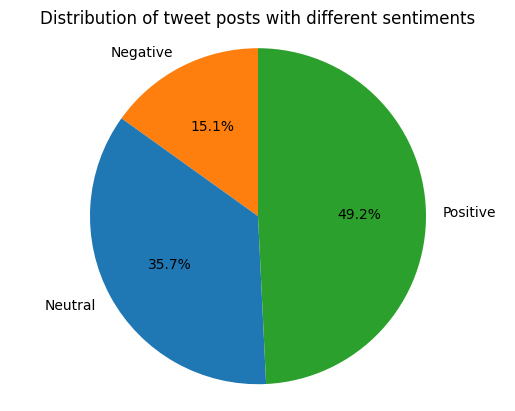

In [15]:
plot_piechart(data)

Neutral     8371
Positive    5183
Negative    2590
Name: sentiment, dtype: int64


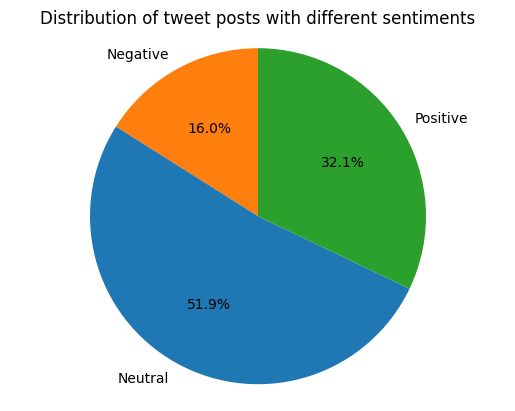

In [16]:
plot_piechart(toot_data)

In [128]:
dic= count_emoji_date(data,'month')
print(dic)

{'2022-02': 137300, '2022-03': 234841, '2022-04': 252032, '2022-05': 259834, '2022-06': 229177, '2022-07': 215355, '2022-08': 72136}


In [122]:
toot_data.iloc[0,:]['created_at'][:4]

'2023'

In [69]:
a,b=find_sentiment('Wordle 680 5/6⬜⬜🟩⬜⬜🟩⬜🟩⬜⬜🟩🟩🟩⬜⬜🟩🟩🟩⬜🟩🟩🟩🟩🟩🟩')
print(a,b)

Sentiment: Neutral
Neutral 0.7479214072227478


In [62]:
def find_emoji_existance(df,emo='🇺🇦'):
    exit=False
    for i in range(len(df)):
        tweet=df.iloc[i,2]
        for e in emoji.distinct_emoji_list(tweet):
            if e == emo:
                print(tweet)
                exit=True
                break
        if exit:
            break
find_emoji_existance(toot_data,'🇺🇦')

How to Init Databases With #Quarkus - Sebastian Daschner 🇺🇦 https://blog.sebastian-daschner.com/entries/init-databases-quarkus#Java
